<a href="https://colab.research.google.com/github/LizzyAn/GUVI/blob/main/Tamil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importing necessary libraries
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import interpolation as inter

In [2]:
def correct_skew(image, delta=1, limit=5):
    def determine_score(arr, angle):
        data = inter.rotate(arr, angle, reshape=False, order=0)
        histogram = np.sum(data, axis=1)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2)
        return histogram, score

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        histogram, score = determine_score(thresh, angle)
        scores.append(score)

    best_angle = angles[scores.index(max(scores))]

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC,
              borderMode=cv2.BORDER_REPLICATE)

    return best_angle, rotated

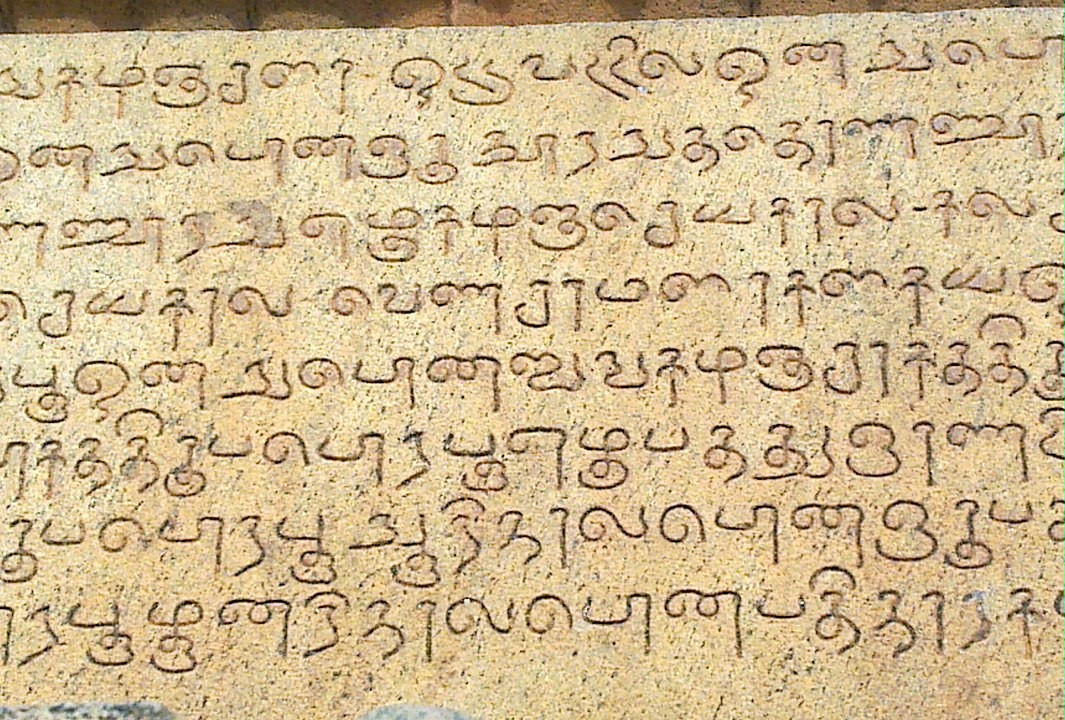

In [3]:
#reading the original image using OpenCV
from google.colab.patches import cv2_imshow
image = cv2.imread('/content/Original.jpg')
cv2_imshow(image)

In [4]:
#Converting the colored image to greyscale
angle, rotated = correct_skew(image)
print(angle)
gray = cv2.cvtColor(rotated,cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

<ipython-input-2-f93a4a34e1fc>:3: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  data = inter.rotate(arr, angle, reshape=False, order=0)


-1


In [5]:
# Remove horizontal lines
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40,1))
remove_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
cnts = cv2.findContours(remove_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(rotated, [c], -1, (255,255,255), 5)

In [6]:
# Remove vertical lines
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,40))
remove_vertical = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
cnts = cv2.findContours(remove_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(rotated, [c], -1, (255,255,255), 5)

In [7]:
gray = cv2.cvtColor(rotated,cv2.COLOR_BGR2GRAY)

In [8]:
#applying median filter for Salt and pepper/impulse noise
filter1 = cv2.medianBlur(gray,5)

In [9]:
#applying gaussian blur to smoothen out the image edges
filter2 = cv2.GaussianBlur(filter1,(5,5),0)

In [10]:
#applying non-localized means for final Denoising of the image
dst = cv2.fastNlMeansDenoising(filter2,None,17,9,17)

In [11]:
#converting the image to binarized form using adaptive thresholding
th1 = cv2.adaptiveThreshold(dst,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)

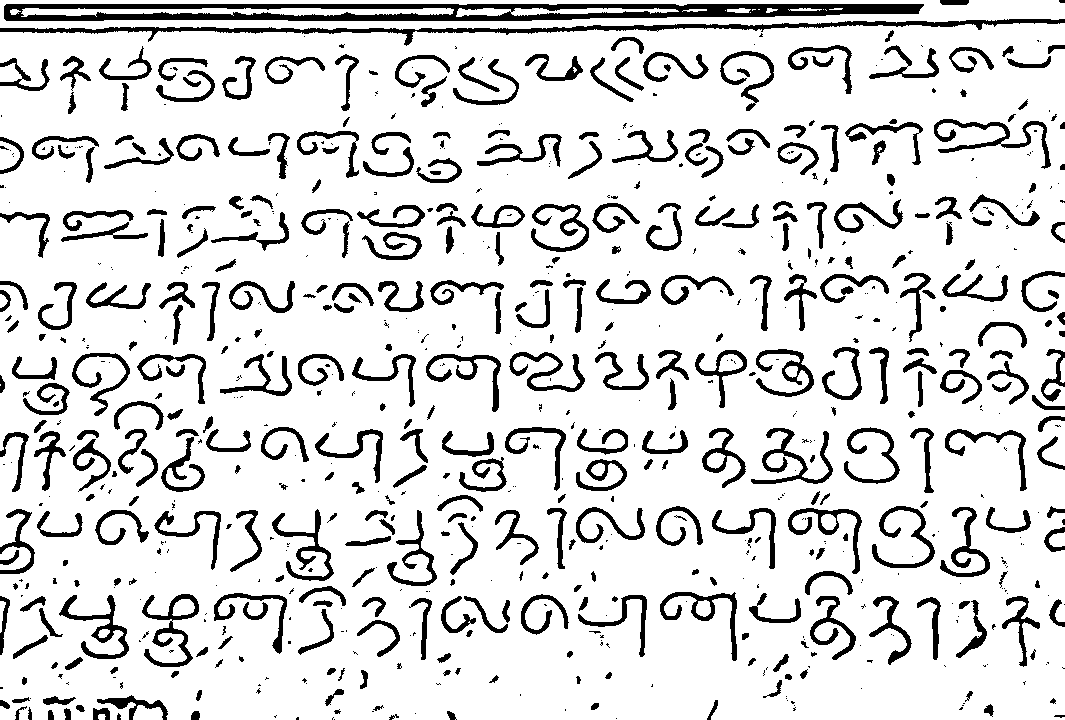

In [12]:
cv2.imwrite('ImagePreProcessingFinal.jpg', th1)
cv2_imshow(th1)

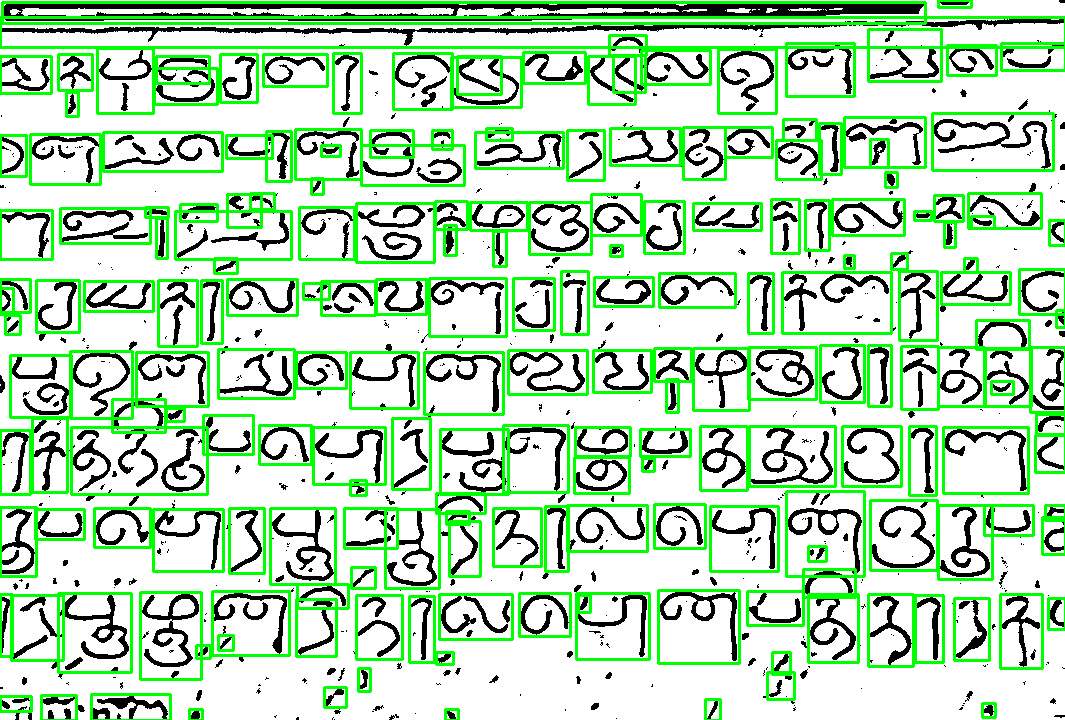

In [13]:
import cv2
import numpy as np
import imutils
from google.colab.patches import cv2_imshow
image = cv2.imread("ImagePreProcessingFinal.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7, 7), 0)
ret, thresh1 = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
dilate = cv2.dilate(thresh1, None, iterations=2)

# Find contours directly without checking OpenCV version
cnts, _ = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter out small contours if needed
min_contour_area = 100
valid_cnts = [cnt for cnt in cnts if cv2.contourArea(cnt) > min_contour_area]

# Convert contours to integer type
valid_cnts = [np.array(cnt, dtype=np.int32) for cnt in valid_cnts]

# Calculate bounding rectangles
bounding_rectangles = [cv2.boundingRect(ctr) for ctr in valid_cnts]

# Sort contours based on y-coordinates of bounding rectangles
sorted_ctrs = [cnt for _, cnt in sorted(zip(bounding_rectangles, valid_cnts), key=lambda x: x[0][1])]

# Create a copy of the original image to draw rectangles on
image_with_rectangles = image.copy()

# Now you can loop through the sorted contours and draw rectangles
for i, ctr in enumerate(sorted_ctrs):
    # Get the bounding rectangle for each contour
    x, y, w, h = bounding_rectangles[i]

    # Draw the rectangle on the copy of the original image
    cv2.rectangle(image_with_rectangles, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Optionally, you can save or display the modified image
    cv2.imwrite(f"output_{i}.png", image_with_rectangles)
img = image_with_rectangles
# Display the final image with rectangles (optional)
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [14]:
orig = image.copy()
i = 0
for cnt in sorted_ctrs:
    # Check the area of contour, if it is very small ignore it
    if(cv2.contourArea(cnt) < 200):
        continue

    # Filtered countours are detected
    x,y,w,h = cv2.boundingRect(cnt)

    # Taking ROI of the cotour
    roi = image[y:y+h, x:x+w]

    # Mark them on the image if you want
    cv2.rectangle(orig,(x,y),(x+w,y+h),(0,255,0),2)

    # Save your contours or characters
    cv2.imwrite("Images/roi" + str(i) + ".png", roi)

    i = i + 1

In [15]:
cv2.imwrite("box.jpg",orig)

True

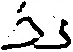

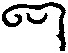

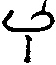

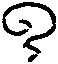

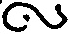

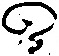

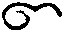

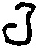

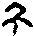

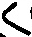

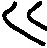

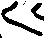

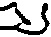

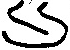

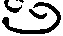

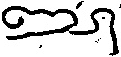

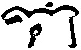

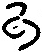

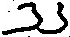

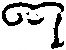

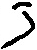

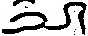

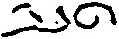

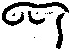

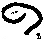

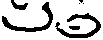

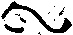

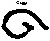

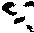

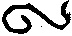

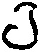

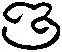

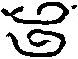

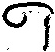

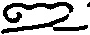

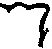

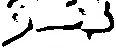

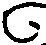

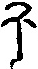

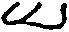

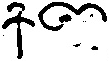

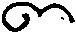

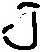

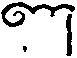

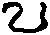

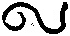

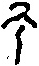

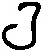

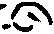

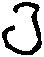

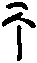

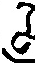

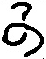

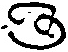

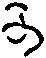

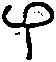

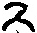

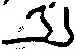

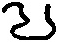

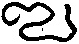

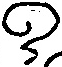

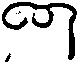

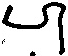

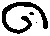

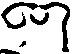

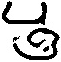

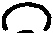

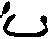

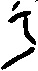

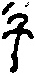

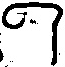

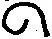

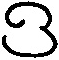

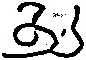

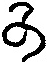

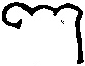

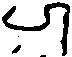

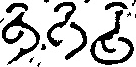

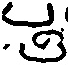

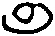

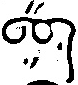

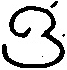

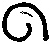

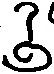

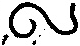

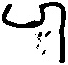

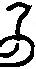

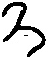

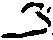

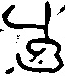

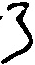

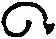

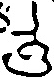

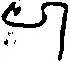

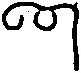

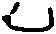

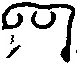

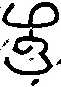

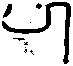

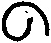

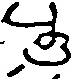

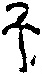

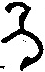

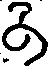

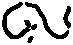

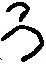

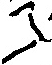

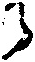

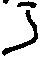

In [16]:
from google.colab.patches import cv2_imshow
orig = image.copy()
i = 0
for cnt in sorted_ctrs:
    # Check the area of the contour; if it is very small, ignore it
    if cv2.contourArea(cnt) < 200:
        continue

    # Filtered contours are detected
    x, y, w, h = cv2.boundingRect(cnt)

    # Taking ROI of the contour
    roi = image[y:y+h, x:x+w]

    # Mark them on the image if you want
    cv2.rectangle(orig, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Save your contours or characters
    cv2.imwrite("Images/roi" + str(i) + ".png", roi)

    # Display each character separately
    cv2_imshow(roi)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    i = i + 1


In [17]:
!apt-get install tesseract-ocr
!apt-get install libtesseract-dev
!pip install pytesseract


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 9 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (1,999 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 120880 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-e

In [18]:
!apt-get install tesseract-ocr-tam



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tesseract-ocr-tam
0 upgraded, 1 newly installed, 0 to remove and 9 not upgraded.
Need to get 1,071 kB of archives.
After this operation, 3,253 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-tam all 1:4.00~git30-7274cfa-1.1 [1,071 kB]
Fetched 1,071 kB in 2s (616 kB/s)
Selecting previously unselected package tesseract-ocr-tam.
(Reading database ... 121060 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-tam_1%3a4.00~git30-7274cfa-1.1_all.deb ...
Unpacking tesseract-ocr-tam (1:4.00~git30-7274cfa-1.1) ...
Setting up tesseract-ocr-tam (1:4.00~git30-7274cfa-1.1) ...


Character 1: 
Character 2:  

 

Character 3: 
Character 4: 
Character 5: 
Character 6: 
Character 7: 
Character 8: 
Character 9: 
Character 10: 
Character 11: 
Character 12: 
Character 13: 
Character 14: 
Character 15: 
Character 16: 
Character 17: 
Character 18: 
Character 19: 
Character 20: 
Character 21:  

Character 22: 
Character 23: 
Character 24: 
Character 25: 
Character 26: 
Character 27: 
Character 28: 
Character 29: 
Character 30: 
Character 31: 
Character 32: 
Character 33: 
Character 34: 
Character 35: \)

Character 36: 
Character 37: 
Character 38: 
Character 39: 
Character 40: 
Character 41: 
Character 42:  

Character 43: 
Character 44: 
Character 45: 
Character 46: 
Character 47: 
Character 48: 
Character 49: 
Character 50: 
Character 51: 
Character 52: 
Character 53:  

Character 54: 
Character 55: 
Character 56: —})

Character 57: 
Character 58: 
Character 59: 
Character 60: 
Character 61: 
Character 62: 

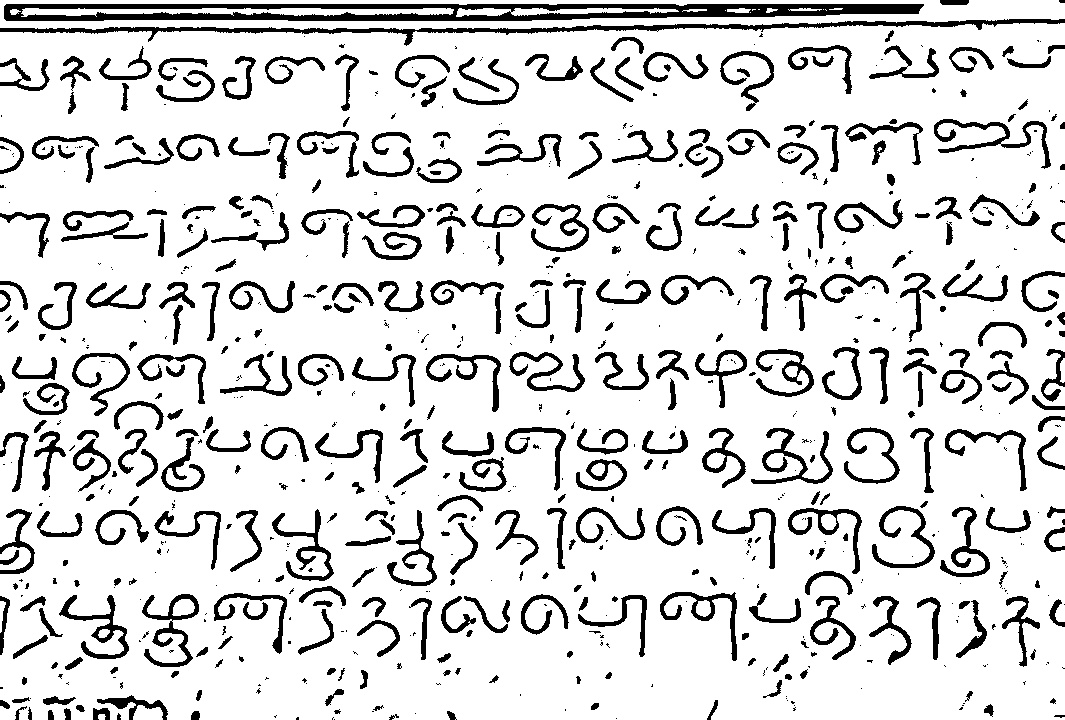

In [ ]:
# Import necessary libraries
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import interpolation as inter
import pytesseract

# ... (your existing code)

# Continue with OCR and text extraction
def extract_text_from_image(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Perform OCR using Tesseract
    text = pytesseract.image_to_string(gray, lang='eng')  # Use the appropriate language code

    return text

# Loop through the segmented characters and perform OCR
for i, cnt in enumerate(sorted_ctrs):
    x, y, w, h = cv2.boundingRect(cnt)
    roi = image[y:y+h, x:x+w]

    # Optional: Further image processing on the character if needed
    # e.g., resizing, additional thresholding, etc.

    # Extract text from the character using OCR
    character_text = extract_text_from_image(roi)

    # Display the recognized text
    print(f"Character {i + 1}: {character_text}")

    # Optionally, you can save or perform additional processing based on the recognized text

# Display the final image with rectangles (optional)
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()


Final Result:
  

 
                    
              \)
        
            
   —})
         
                                —))
   
           9
             6C
      
  \VY
                                       
   +f
      uN
                           
     


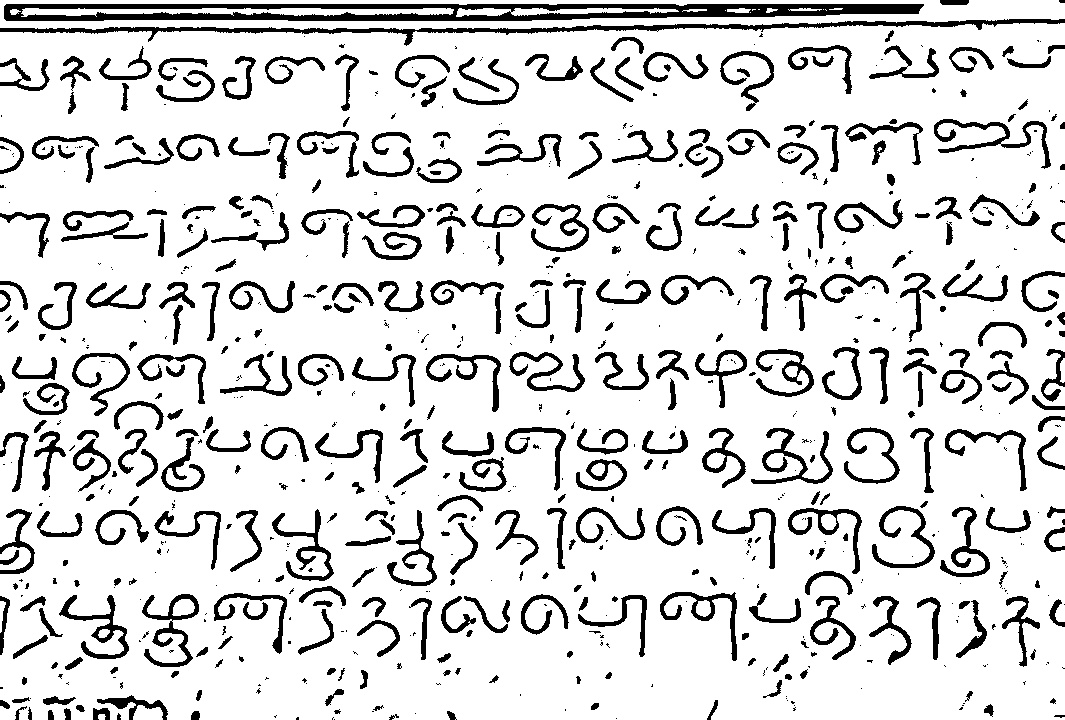

In [ ]:
# Import necessary libraries
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import interpolation as inter
import pytesseract

# ... (your existing code)

# Continue with OCR and text extraction
def extract_text_from_image(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Perform OCR using Tesseract with Tamil and English language settings
    text = pytesseract.image_to_string(gray, lang='eng')  # Use 'eng+ta' for English and Tamil

    return text

# Variable to store all recognized texts
all_texts = []

# Loop through the segmented characters and perform OCR
for i, cnt in enumerate(sorted_ctrs):
    x, y, w, h = cv2.boundingRect(cnt)
    roi = image[y:y+h, x:x+w]

    # Optional: Further image processing on the character if needed
    # e.g., resizing, additional thresholding, etc.

    # Extract text from the character using OCR
    character_text = extract_text_from_image(roi)

    # Append the recognized text to the list
    all_texts.append(character_text)

# Concatenate all recognized texts into a single string
final_result = ' '.join(all_texts)

# Display the final result
print("Final Result:")
print(final_result)

# Display the final image with rectangles (optional)
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
!pip install langid


Final Result:
\) —}) —)) 9 6C \VY +f uN


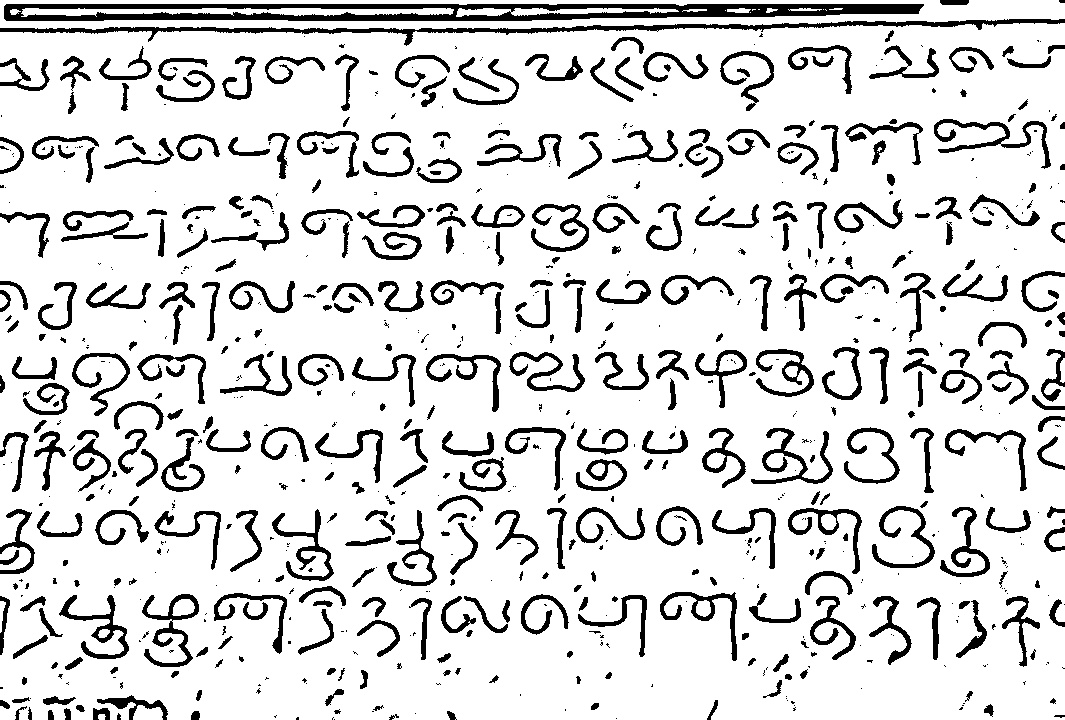

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import interpolation as inter
import pytesseract
import re

# ... (your existing code)

# Continue with OCR and text extraction
def extract_text_from_image(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Perform OCR using Tesseract with Tamil and English language settings
    text = pytesseract.image_to_string(gray, lang='eng+ta')  # Use 'eng+ta' for English and Tamil

    return text

# Variable to store all recognized texts
all_texts = []

# Loop through the segmented characters and perform OCR
for i, cnt in enumerate(sorted_ctrs):
    x, y, w, h = cv2.boundingRect(cnt)
    roi = image[y:y+h, x:x+w]

    # Optional: Further image processing on the character if needed
    # e.g., resizing, additional thresholding, etc.

    # Extract text from the character using OCR
    character_text = extract_text_from_image(roi)

    # Append the recognized text to the list
    all_texts.append(character_text)

    color = tuple(np.random.randint(0, 255, 3).tolist())


# Concatenate all recognized texts into a single string
final_result = ' '.join(all_texts)

# Clean up whitespaces in the final result
final_result_cleaned = re.sub(r'\s+', ' ', final_result).strip()

# Display the final result
print("Final Result:")
print(final_result_cleaned)

# Display the final image with rectangles (optional)
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()


Final Result:
---------------------------
\va manava mavava ya rava tha in o
--------------------------


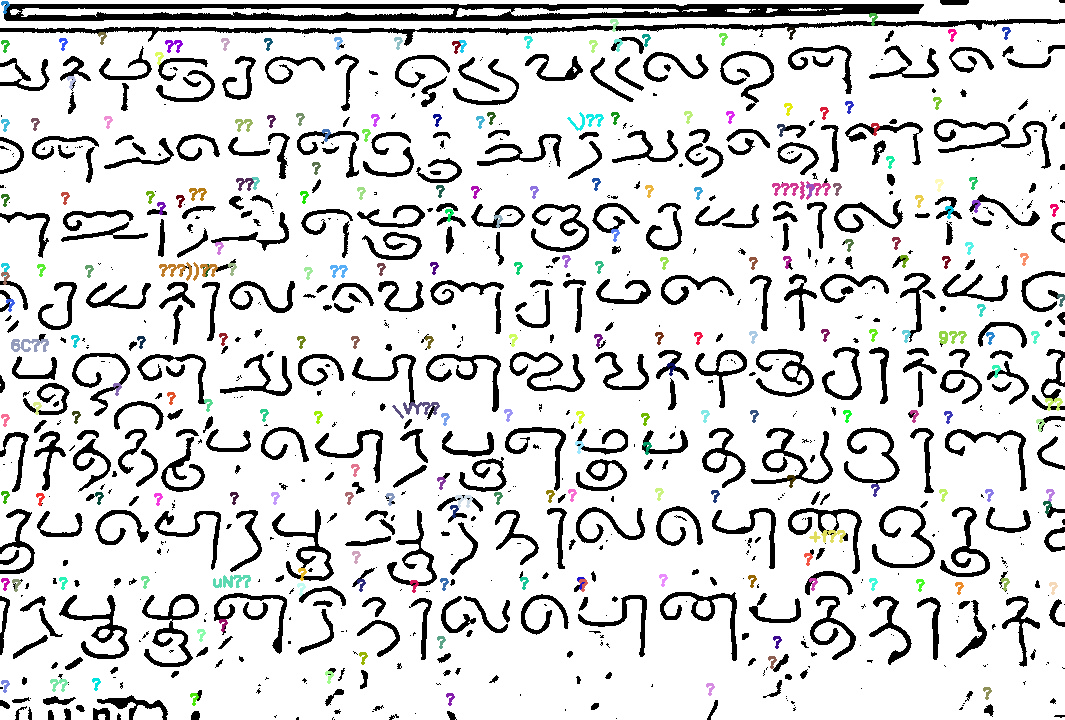

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import interpolation as inter
import pytesseract
import re

# ... (your existing code)

# Mapping of characters to meaningful sounds in Tamil
tamil_mapping = {
    ')': 'va',
    '}': 'na',
    '—': 'ma',
    '9': 'ya',
    '6': 'ra',
    'C': 'va',
    '\VY': 'tha',
    '+f': 'in',
    '\)': 'cha',
   '—})':'poo',
    '6C':'pi',
     'uN':'o',
     'Le':'pa',
     'V':'ka',
     'Y':'laa',
    '(':'la',
    ',':'naa',
    ':':'koo'
}

# Function to replace characters based on the mapping
def replace_tamil_characters(text, mapping):
    for char, sound in mapping.items():
        text = text.replace(char, sound)
    return text

# Continue with OCR and text extraction
def extract_text_from_image(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Perform OCR using Tesseract with Tamil and English language settings
    text = pytesseract.image_to_string(gray, lang='eng+ta')  # Use 'eng+ta' for English and Tamil

    return text

# Variable to store all recognized texts
all_texts = []

# Loop through the segmented characters and perform OCR
for i, cnt in enumerate(sorted_ctrs):
    x, y, w, h = cv2.boundingRect(cnt)
    roi = image[y:y+h, x:x+w]

    # Optional: Further image processing on the character if needed
    # e.g., resizing, additional thresholding, etc.

    # Extract text from the character using OCR
    character_text = extract_text_from_image(roi)

    # Append the recognized text to the list
    all_texts.append(character_text)

    color = tuple(np.random.randint(0, 255, 3).tolist())
    cv2.putText(image, character_text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Concatenate all recognized texts into a single string
final_result = ' '.join(all_texts)

# Clean up whitespaces in the final result
final_result_cleaned = re.sub(r'\s+', ' ', final_result).strip()

# Replace characters based on the Tamil mapping
final_result_meaningful = replace_tamil_characters(final_result_cleaned, tamil_mapping)

# Display the final result
print("Final Result:")
print("---------------------------")
print(final_result_meaningful)
print("--------------------------")

# Display the final image with rectangles (optional)  ra makara marara ya lava na uN uN
cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()
